In [1]:
import grizli
import numpy as np
import matplotlib.pyplot as plt
from vtl.Readfile import Readfile
from scipy.interpolate import interp1d
from astropy.table import Table
from astropy.io import fits
from collections import OrderedDict
import astropy.wcs as pywcs
import pysynphot as S
import seaborn as sea

sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1, as_cmap=True)

Define Function to change flux into magnitudes

In [2]:
def Mag(band):
    magnitude=25-2.5*np.log10(band)
    return magnitude

Create initial model

In [67]:
pad=100
# grism_input='/Users/Vince.ec/Clear_data/flt_files/icxt52i0q_flt.fits'
# reference_image='/Users/Vince.ec/Clear_data/goodsn_mosaic/goodsn_3dhst.v4.0.F125W_orig_sci.fits'
# segment_map='/Users/Vince.ec/Clear_data/goodsn_mosaic/goodsn_3dhst.v4.0.F160W_seg.fits'

grism_input='/Users/Vince.ec/Clear_data/flt_files/icxt30s0q_flt.fits'
reference_image='/Users/Vince.ec/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F125W_orig_sci.fits'
segment_map='/Users/Vince.ec/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F160W_seg.fits'

sim_g102 = grizli.model.GrismFLT(grism_file=grism_input,verbose=True,ref_file=reference_image,seg_file=segment_map,force_grism='G102',pad=pad)

Image cutout: x=slice(6340, 10445, None), y=slice(12710, 16937, None)
/Users/Vince.ec/Clear_data/flt_files/icxt30s0q_flt.fits / blot reference /Users/Vince.ec/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F125W_orig_sci.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(6340, 10445, None), y=slice(12710, 16937, None)
/Users/Vince.ec/Clear_data/flt_files/icxt30s0q_flt.fits / Pad ref HDU with 50 pixels
/Users/Vince.ec/Clear_data/flt_files/icxt30s0q_flt.fits / blot segmentation /Users/Vince.ec/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F160W_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


Read in catalogs

In [68]:
# ref_cat=Table.read(fits.open('/Users/Vince.ec/Clear_data/goodsn_mosaic/goodsn_3dhst.v4.3.cat.FITS')[1])
ref_cat=Table.read('/Users/Vince.ec/Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat',format='ascii')
sim_cat=sim_g102.blot_catalog(ref_cat,sextractor=False)

Select objects

In [69]:
mask = Mag(sim_cat['f_F125W']) < 27
 
print('N=%d' %(mask.sum()))

sim_g102.compute_full_model(ids=sim_cat['id'], mags=Mag(sim_cat['f_F125W']))

N=1148


Locate object

In [80]:
# gal_id =21156
# gal_id=40597
gal_id=40891
obj_mag = Mag(ref_cat['f_F125W'][np.argwhere(ref_cat['id']==gal_id)])
print('ID:%d, mag=%.2f' %(gal_id, obj_mag))

ID:40891, mag=19.96


Create cutout

In [81]:
beam_g102 = grizli.model.BeamCutout(sim_g102, sim_g102.object_dispersers[gal_id]['A'])
print 'cutout done'

cutout done


Simulate spectra

In [82]:
wave, fl = np.array(Readfile('/Users/Vince.ec/fsps_models_for_fit/fsps_spec/m0.027_a3.4_t8.86_spec.dat'))

## redshift spec
spec = S.ArraySpectrum(wave, fl, fluxunits='flam')
spec = spec.redshift(1.256).renorm(1., 'flam', S.ObsBandpass('wfc3,ir,f125w'))
spec.convert('flam')

## Compute the models
beam_g102.compute_model(spectrum_1d=[spec.wave,spec.flux])

## Extractions the model (error array here is meaningless)
w, f, e = beam_g102.beam.optimal_extract(beam_g102.model,bin=0)

## Get sensitivity function
fwv, ffl = [beam_g102.beam.lam, beam_g102.beam.sensitivity / np.max(beam_g102.beam.sensitivity)]
filt = interp1d(fwv, ffl)

## Clip model to fit in interpolation
clip = []
for iii in range(len(w)):
    if fwv[0] < w[iii] < fwv[-1]:
        clip.append(iii)

w = w[clip]
f = f[clip]

f /= filt(w)

ID1=[U for U in range(len(w)) if 7900 < w[U] <11300]

Plot results

86


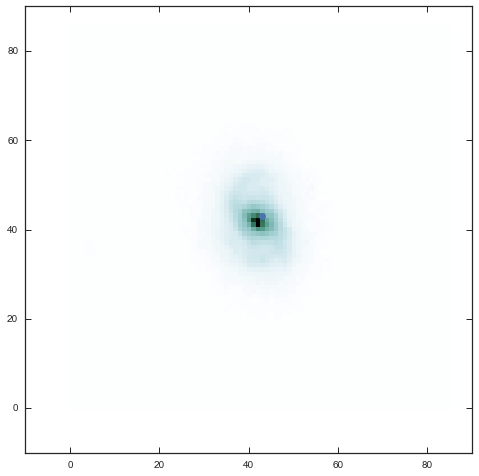

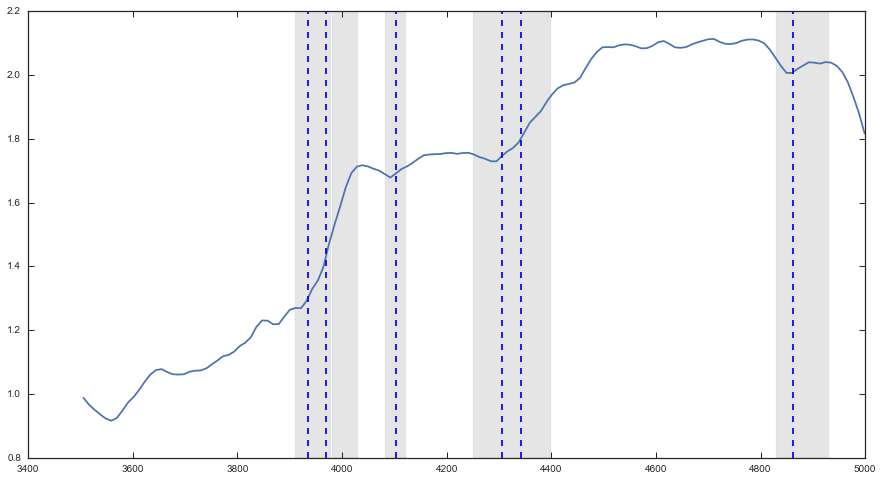

In [85]:
%matplotlib inline

print len(beam_g102.beam.direct)

###show cutout
plt.figure(figsize=[8,8])
plt.imshow(beam_g102.beam.direct*(beam_g102.beam.seg == gal_id), interpolation='Nearest', cmap=colmap, origin='lower')
plt.plot(len(beam_g102.beam.direct)/2,len(beam_g102.beam.direct)/2,'o')
plt.show()
plt.close()

###plot spectra
plt.figure(figsize=[15,8])
plt.plot(w[ID1]/2.256,f[ID1])
# plt.plot(w[ID1]/2.249,f[ID1])
plt.axvline(3934.777,linestyle='--')
plt.axvline(3969.588,linestyle='--')
plt.axvline(4102.89,linestyle='--')
plt.axvline(4305.61,linestyle='--')
plt.axvline(4341.68,linestyle='--')
plt.axvline(4862.68,linestyle='--')
plt.axvspan(3910, 3979, color='k', alpha=.1)
plt.axvspan(3981, 4030, color='k', alpha=.1)
plt.axvspan(4082, 4122, color='k', alpha=.1)
plt.axvspan(4250, 4400, color='k', alpha=.1)
plt.axvspan(4830, 4930, color='k', alpha=.1)
plt.show()
plt.close()